# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

When finished, you can close the environment.

In [5]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import datetime

import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        
        if ACTOR_NORMALIZE_STATES:
            self.normalizer_states = nn.BatchNorm1d(state_size)
        
        if ACTOR_NORMALIZE:
            self.normalizer = nn.BatchNorm1d(fc1_units)
            
        if ACTOR_DROPOUT:
            self.dropout = nn.Dropout(p = ACTOR_DROPOUT_RATE)
            
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.out = nn.Linear(fc2_units, action_size)
        
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.out.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, states):
        """Build an actor (policy) network that maps states -> actions."""
        x = states      
        
        if ACTOR_NORMALIZE_STATES:
            x = self.normalizer_states(x)
        
        x = self.fc1(x)
        
        if ACTOR_NORMALIZE:
            x = self.normalizer(x)
        
        x = F.relu(x)
        x = F.relu(self.fc2(x))
        
        if ACTOR_DROPOUT:
            x = self.dropout(x)
        
        return torch.tanh(self.out(x))

class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        
        if CRITIC_NORMALIZE_STATES:
            self.normalizer_states = nn.BatchNorm1d(state_size)
        
        if CRITIC_NORMALIZE:
            self.normalizer = nn.BatchNorm1d(fcs1_units)
            
        if CRITIC_DROPOUT:
            self.dropout = nn.Dropout(p = CRITIC_DROPOUT_RATE)
            
        self.seed = torch.manual_seed(seed)
        
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, states, actions):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = states
        
        if CRITIC_NORMALIZE_STATES:
            xs = self.normalizer_states(xs)
        
        xs = self.fcs1(xs)
        
        if CRITIC_NORMALIZE:
            xs = self.normalizer(xs)
            
        xs = F.relu(xs)            
        x = torch.cat((xs, actions), dim=1)
        x = F.relu(self.fc2(x))
        
        if CRITIC_DROPOUT:
            x = self.dropout(x)
        
        return self.fc3(x)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [28]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, device, state_size, action_size, random_seed, memory,
                 ac1 = 400, ac2 = 300, cc1 = 400, cc2 = 300):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.noise_epsilon = NOISE_EPSILON
        
        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed, fc1_units = ac1, fc2_units = ac2).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed, fc1_units = ac1, fc2_units = ac2).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed, fcs1_units = cc1, fc2_units = cc2).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed, fcs1_units = cc1, fc2_units = cc2).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = memory
    
    def step(self, t):
        """Save experience in replay memory, and use random sample from buffer to learn."""

        if t % DDPG_UPDATE_EVERY == 0 and len(self.memory) > BATCH_SIZE:
            for _ in range(DDPG_LEARN_TIMES):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)            
        
    def act(self, states, add_noise=True):
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        self.actor_local.eval()
        
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
            
        self.actor_local.train()
        
        if add_noise:
            actions += self.noise_epsilon * self.noise.sample()
            
        return np.clip(actions, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)   
        
        # ---------------------------- update noise ---------------------------- #
        self.noise_epsilon = max(NOISE_EPSILPN_MIN, self.noise_epsilon - NOISE_EPSILON_DECAY)
        self.noise.reset()

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [29]:
def maddpg(n_episodes, max_t, memory, window_size=100, print_every=10, early_break=False):
    scores_deque = deque(maxlen=window_size)
    scores_short = deque(maxlen=10)
    all_scores = []
    start_time = datetime.datetime.now().strftime("%H:%M:%S")
    print('{} Starts training'.format(start_time))
    
    for i_episode in range(1, n_episodes+1):
        
        for agent in agents:
            agent.reset()
            
        env_info = env.reset(train_mode=True)[brain_name]
        all_states = env_info.vector_observations
        scores = np.zeros(2)
        
        for t in range(max_t):
            actions = [agent.act(np.expand_dims(states, axis=0)) for agent, states in zip(agents, all_states)]           

            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            # Update Replay Buffer
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                memory.add(state, action, reward, next_state, done)
            
            # Perform agent step
            for agent in agents:            
                agent.step(t)

            all_states = next_states
            scores += rewards
            
            if early_break and np.any(dones):
                break

        max_score = np.max(scores)
        scores_deque.append(max_score)
        scores_short.append(max_score)
        all_scores.append(max_score)            
             
        current_time = datetime.datetime.now().strftime("%H:%M:%S")
        debug_string = '{} Episode {}\t Episode score: {:.3f}\tScore (last 10): {:.3f}\tAverage rolling for last 100: {:.3f}'.format(current_time, i_episode, max_score, np.mean(scores_short), np.mean(scores_deque))
            
        if i_episode % print_every == 0 or max_score > 0.001:               
            print(debug_string)
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
           
        if np.mean(scores_deque)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode-100, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return all_scores

In [9]:
BUFFER_SIZE = int(1e6)        # replay buffer size
BATCH_SIZE = 512              # minibatch size
GAMMA = 0.99                  # discount factor
TAU = 1e-3                    # for soft update of target parameters
LR_ACTOR = 1e-3               # learning rate of the actor 
LR_CRITIC = 3e-3              # learning rate of the critic
WEIGHT_DECAY = 0              # L2 weight decay

DDPG_LEARN_TIMES = 4
DDPG_UPDATE_EVERY = 1

NOISE_EPSILON = 5.0           # explore/exploit from the noise generator
NOISE_EPSILON_DECAY = 1e-3    # decay rate for noise process

ACTOR_DROPOUT = False         # Actor: use dropout (on last layer)
ACTOR_DROPOUT_RATE = 0.1      # Actor: dropout rate
ACTOR_NORMALIZE = True

CRITIC_DROPOUT = False        # Critic: use dropout (on last layer)
CRITIC_DROPOUT_RATE = 0.05    # Critic: dropout rate
CRITIC_NORMALIZE = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

shared_memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, 2)
agents = [Agent(state_size=state_size, action_size=action_size, device=device, random_seed=2, memory = shared_memory,
              ac1=512, ac2=256, cc1=512, cc2=256) for _ in range(2)]

Using device: cuda:0


22:53:00 Starts training
22:54:47 Episode 1	 Episode score: -0.150	Score (last 10): -0.150	Average rolling for last 100: -0.150
22:56:34 Episode 2	 Episode score: -0.150	Score (last 10): -0.150	Average rolling for last 100: -0.150
22:58:21 Episode 3	 Episode score: -0.160	Score (last 10): -0.153	Average rolling for last 100: -0.153
23:00:08 Episode 4	 Episode score: -0.120	Score (last 10): -0.145	Average rolling for last 100: -0.145
23:01:54 Episode 5	 Episode score: -0.150	Score (last 10): -0.146	Average rolling for last 100: -0.146
23:03:41 Episode 6	 Episode score: -0.170	Score (last 10): -0.150	Average rolling for last 100: -0.150
23:05:29 Episode 7	 Episode score: -0.110	Score (last 10): -0.144	Average rolling for last 100: -0.144
23:07:18 Episode 8	 Episode score: -0.070	Score (last 10): -0.135	Average rolling for last 100: -0.135
23:09:06 Episode 9	 Episode score: -0.170	Score (last 10): -0.139	Average rolling for last 100: -0.139
23:10:53 Episode 10	 Episode score: -0.130	Score

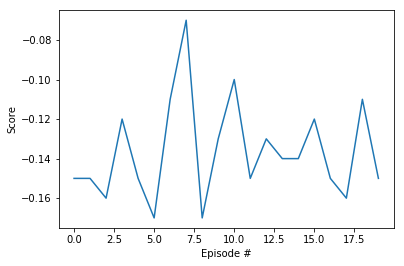

In [11]:
scores = maddpg(20, 500, early_break = False, memory = shared_memory, print_every = 1)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

20:19:02 Starts training
20:26:22 Episode 4	 Episode score: -0.090	Score (last 10): -0.127	Average rolling for last 100: -0.127
20:33:42 Episode 8	 Episode score: -0.150	Score (last 10): -0.144	Average rolling for last 100: -0.144
20:40:59 Episode 12	 Episode score: -0.170	Score (last 10): -0.148	Average rolling for last 100: -0.146
20:48:19 Episode 16	 Episode score: -0.140	Score (last 10): -0.154	Average rolling for last 100: -0.148
20:55:41 Episode 20	 Episode score: -0.150	Score (last 10): -0.151	Average rolling for last 100: -0.146


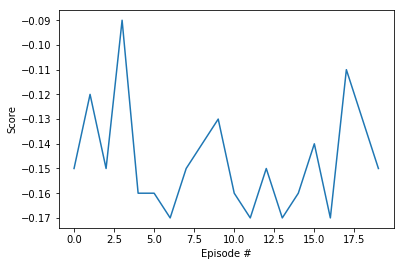

In [12]:
scores = maddpg(20, 500, early_break = False, memory = shared_memory, print_every = 4)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Using device: cuda:0
20:59:42 Starts training
21:06:05 Episode 4	 Episode score: -0.150	Score (last 10): -0.127	Average rolling for last 100: -0.127
21:13:23 Episode 8	 Episode score: -0.140	Score (last 10): -0.131	Average rolling for last 100: -0.131
21:20:40 Episode 12	 Episode score: -0.150	Score (last 10): -0.145	Average rolling for last 100: -0.138
21:27:57 Episode 16	 Episode score: -0.160	Score (last 10): -0.148	Average rolling for last 100: -0.143
21:35:15 Episode 20	 Episode score: -0.160	Score (last 10): -0.159	Average rolling for last 100: -0.147


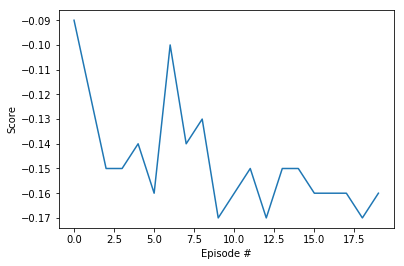

In [13]:
BUFFER_SIZE = int(1e6)        # replay buffer size
BATCH_SIZE = 512              # minibatch size
GAMMA = 0.99                  # discount factor
TAU = 1e-3                    # for soft update of target parameters
LR_ACTOR = 1e-3               # learning rate of the actor 
LR_CRITIC = 3e-3              # learning rate of the critic
WEIGHT_DECAY = 0              # L2 weight decay

DDPG_LEARN_TIMES = 4
DDPG_UPDATE_EVERY = 1

NOISE_EPSILON = 5.0           # explore/exploit from the noise generator
NOISE_EPSILON_DECAY = 1e-3    # decay rate for noise process

ACTOR_DROPOUT = True          # Actor: use dropout (on last layer)
ACTOR_DROPOUT_RATE = 0.1      # Actor: dropout rate
ACTOR_NORMALIZE = True

CRITIC_DROPOUT = True         # Critic: use dropout (on last layer)
CRITIC_DROPOUT_RATE = 0.05    # Critic: dropout rate
CRITIC_NORMALIZE = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

shared_memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, 2)
agents = [Agent(state_size=state_size, action_size=action_size, device=device, random_seed=2, memory = shared_memory,
              ac1=512, ac2=256, cc1=512, cc2=256) for _ in range(2)]

scores = maddpg(20, 500, early_break = False, memory = shared_memory, print_every = 4)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Max t = 2000

Using device: cuda:0
21:35:15 Starts training
21:37:00 Episode 3	 Episode score: 0.140	Score (last 10): -0.173	Average rolling for last 100: -0.173
21:37:36 Episode 4	 Episode score: -0.440	Score (last 10): -0.240	Average rolling for last 100: -0.240
21:40:01 Episode 8	 Episode score: -0.560	Score (last 10): -0.419	Average rolling for last 100: -0.419
21:42:26 Episode 12	 Episode score: -0.620	Score (last 10): -0.533	Average rolling for last 100: -0.499
21:44:53 Episode 16	 Episode score: -0.620	Score (last 10): -0.629	Average rolling for last 100: -0.527
21:47:19 Episode 20	 Episode score: -0.550	Score (last 10): -0.623	Average rolling for last 100: -0.546


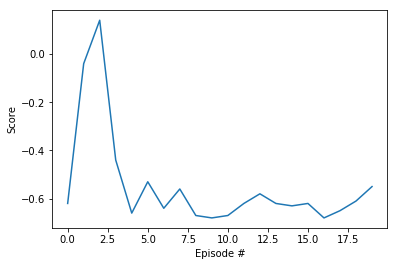

In [14]:
BUFFER_SIZE = int(1e6)        # replay buffer size
BATCH_SIZE = 512              # minibatch size
GAMMA = 0.99                  # discount factor
TAU = 1e-3                    # for soft update of target parameters
LR_ACTOR = 1e-4               # learning rate of the actor 
LR_CRITIC = 3e-4              # learning rate of the critic
WEIGHT_DECAY = 0              # L2 weight decay

DDPG_LEARN_TIMES = 1
DDPG_UPDATE_EVERY = 4

NOISE_EPSILON = 5.0           # explore/exploit from the noise generator
NOISE_EPSILON_DECAY = 1e-3    # decay rate for noise process

ACTOR_DROPOUT = True          # Actor: use dropout (on last layer)
ACTOR_DROPOUT_RATE = 0.1      # Actor: dropout rate
ACTOR_NORMALIZE = True

CRITIC_DROPOUT = True         # Critic: use dropout (on last layer)
CRITIC_DROPOUT_RATE = 0.05    # Critic: dropout rate
CRITIC_NORMALIZE = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

shared_memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, 2)
agents = [Agent(state_size=state_size, action_size=action_size, device=device, random_seed=2, memory = shared_memory,
              ac1=512, ac2=256, cc1=512, cc2=256) for _ in range(2)]

scores = maddpg(20, 2000, early_break = False, memory = shared_memory, print_every = 4)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Using device: cuda:0
21:57:41 Starts training
22:00:46 Episode 3	 Episode score: 0.300	Score (last 10): -0.213	Average rolling for last 100: -0.213
22:01:50 Episode 4	 Episode score: 1.040	Score (last 10): 0.100	Average rolling for last 100: 0.100
22:05:59 Episode 8	 Episode score: -0.620	Score (last 10): -0.211	Average rolling for last 100: -0.211
22:10:10 Episode 12	 Episode score: -0.660	Score (last 10): -0.331	Average rolling for last 100: -0.354
22:14:24 Episode 16	 Episode score: -0.640	Score (last 10): -0.647	Average rolling for last 100: -0.429
22:18:40 Episode 20	 Episode score: -0.640	Score (last 10): -0.655	Average rolling for last 100: -0.476


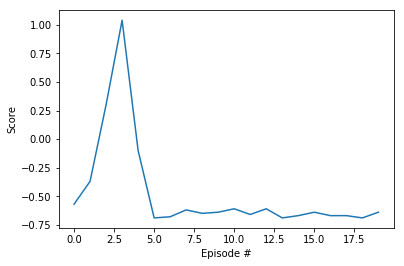

In [17]:
BUFFER_SIZE = int(1e6)        # replay buffer size
BATCH_SIZE = 512              # minibatch size
GAMMA = 0.99                  # discount factor
TAU = 1e-3                    # for soft update of target parameters
LR_ACTOR = 1e-4               # learning rate of the actor 
LR_CRITIC = 3e-4              # learning rate of the critic
WEIGHT_DECAY = 0              # L2 weight decay

DDPG_LEARN_TIMES = 2
DDPG_UPDATE_EVERY = 4

NOISE_EPSILPN_MIN = 1e-2
NOISE_EPSILON = 8.0           # explore/exploit from the noise generator
NOISE_EPSILON_DECAY = 1e-3    # decay rate for noise process

ACTOR_DROPOUT = True          # Actor: use dropout (on last layer)
ACTOR_DROPOUT_RATE = 0.1      # Actor: dropout rate
ACTOR_NORMALIZE = True

CRITIC_DROPOUT = True         # Critic: use dropout (on last layer)
CRITIC_DROPOUT_RATE = 0.05    # Critic: dropout rate
CRITIC_NORMALIZE = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

shared_memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, 2)
agents = [Agent(state_size=state_size, action_size=action_size, device=device, random_seed=2, memory = shared_memory,
              ac1=512, ac2=256, cc1=512, cc2=256) for _ in range(2)]

scores = maddpg(20, 2000, early_break = False, memory = shared_memory, print_every = 4)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Using device: cuda:0
22:18:58 Starts training
22:24:42 Episode 4	 Episode score: -0.640	Score (last 10): -0.645	Average rolling for last 100: -0.645
22:31:17 Episode 8	 Episode score: -0.660	Score (last 10): -0.649	Average rolling for last 100: -0.649
22:37:57 Episode 12	 Episode score: -0.670	Score (last 10): -0.650	Average rolling for last 100: -0.649
22:44:45 Episode 16	 Episode score: -0.630	Score (last 10): -0.650	Average rolling for last 100: -0.649
22:51:50 Episode 20	 Episode score: -0.630	Score (last 10): -0.642	Average rolling for last 100: -0.643


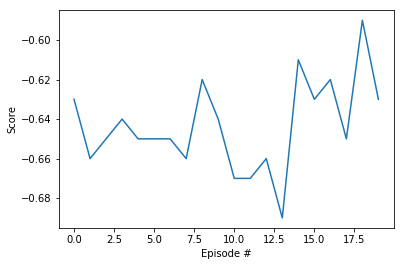

In [18]:
BUFFER_SIZE = int(1e6)        # replay buffer size
BATCH_SIZE = 2048             # minibatch size
GAMMA = 0.99                  # discount factor
TAU = 1e-3                    # for soft update of target parameters
LR_ACTOR = 1e-4               # learning rate of the actor 
LR_CRITIC = 3e-4              # learning rate of the critic
WEIGHT_DECAY = 0              # L2 weight decay

DDPG_LEARN_TIMES = 2
DDPG_UPDATE_EVERY = 4

NOISE_EPSILPN_MIN = 1e-2
NOISE_EPSILON = 8.0           # explore/exploit from the noise generator
NOISE_EPSILON_DECAY = 1e-3    # decay rate for noise process

ACTOR_DROPOUT = True          # Actor: use dropout (on last layer)
ACTOR_DROPOUT_RATE = 0.1      # Actor: dropout rate
ACTOR_NORMALIZE = True

CRITIC_DROPOUT = True         # Critic: use dropout (on last layer)
CRITIC_DROPOUT_RATE = 0.05    # Critic: dropout rate
CRITIC_NORMALIZE = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

shared_memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, 2)
agents = [Agent(state_size=state_size, action_size=action_size, device=device, random_seed=2, memory = shared_memory,
              ac1=512, ac2=256, cc1=512, cc2=256) for _ in range(2)]

scores = maddpg(20, 2000, early_break = False, memory = shared_memory, print_every = 4)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Using device: cuda:0
22:51:51 Starts training
22:55:54 Episode 4	 Episode score: -0.670	Score (last 10): -0.652	Average rolling for last 100: -0.652
23:00:04 Episode 8	 Episode score: -0.640	Score (last 10): -0.645	Average rolling for last 100: -0.645
23:04:21 Episode 12	 Episode score: -0.660	Score (last 10): -0.652	Average rolling for last 100: -0.647
23:08:41 Episode 16	 Episode score: -0.630	Score (last 10): -0.616	Average rolling for last 100: -0.634
23:12:57 Episode 20	 Episode score: -0.680	Score (last 10): -0.636	Average rolling for last 100: -0.639


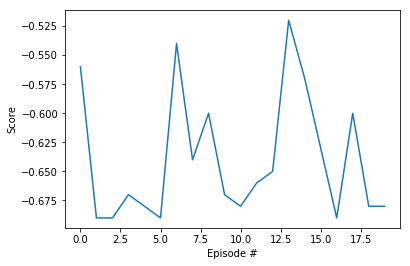

In [19]:
BUFFER_SIZE = int(1e6)        # replay buffer size
BATCH_SIZE = 512              # minibatch size
GAMMA = 0.99                  # discount factor
TAU = 1e-3                    # for soft update of target parameters
LR_ACTOR = 1e-4               # learning rate of the actor 
LR_CRITIC = 3e-4              # learning rate of the critic
WEIGHT_DECAY = 0              # L2 weight decay

DDPG_LEARN_TIMES = 2
DDPG_UPDATE_EVERY = 4

NOISE_EPSILPN_MIN = 1e-2
NOISE_EPSILON = 8.0           # explore/exploit from the noise generator
NOISE_EPSILON_DECAY = 1e-3    # decay rate for noise process

ACTOR_DROPOUT = True          # Actor: use dropout (on last layer)
ACTOR_DROPOUT_RATE = 0.1      # Actor: dropout rate
ACTOR_NORMALIZE = True

CRITIC_DROPOUT = True         # Critic: use dropout (on last layer)
CRITIC_DROPOUT_RATE = 0.05    # Critic: dropout rate
CRITIC_NORMALIZE = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

shared_memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, 2)
agents = [Agent(state_size=state_size, action_size=action_size, device=device, random_seed=2, memory = shared_memory,
              ac1=512, ac2=256, cc1=512, cc2=256) for _ in range(2)]

scores = maddpg(20, 2000, early_break = False, memory = shared_memory, print_every = 4)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [34]:
BUFFER_SIZE = int(1e8)        # replay buffer size
BATCH_SIZE = 512              # minibatch size
GAMMA = 0.99                  # discount factor
TAU = 1e-3                    # for soft update of target parameters
LR_ACTOR = 1e-4               # learning rate of the actor 
LR_CRITIC = 3e-4              # learning rate of the critic
WEIGHT_DECAY = 0              # L2 weight decay

DDPG_LEARN_TIMES = 2
DDPG_UPDATE_EVERY = 4

NOISE_EPSILPN_MIN = 1e-2
NOISE_EPSILON = 8.0           # explore/exploit from the noise generator
NOISE_EPSILON_DECAY = 1e-3    # decay rate for noise process

ACTOR_DROPOUT = False         # Actor: use dropout (on last layer)
ACTOR_DROPOUT_RATE = 0.10     # Actor: dropout rate
ACTOR_NORMALIZE = False
ACTOR_NORMALIZE_STATES = True #

CRITIC_DROPOUT = True         # Critic: use dropout (on last layer)
CRITIC_DROPOUT_RATE = 0.20    # Critic: dropout rate
CRITIC_NORMALIZE = False
CRITIC_NORMALIZE_STATES = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

shared_memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, 2)
agents = [Agent(state_size=state_size, action_size=action_size, device=device, random_seed=2, memory = shared_memory,
              ac1=512, ac2=256, cc1=512, cc2=256) for _ in range(2)]

scores = maddpg(50, 2000, early_break = False, memory = shared_memory, print_every = 4)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Using device: cuda:0
00:01:38 Starts training
00:05:47 Episode 4	 Episode score: -0.650	Score (last 10): -0.665	Average rolling for last 100: -0.665
00:09:56 Episode 8	 Episode score: -0.630	Score (last 10): -0.646	Average rolling for last 100: -0.646
00:14:06 Episode 12	 Episode score: -0.690	Score (last 10): -0.635	Average rolling for last 100: -0.642
00:18:18 Episode 16	 Episode score: -0.660	Score (last 10): -0.633	Average rolling for last 100: -0.642
00:22:33 Episode 20	 Episode score: -0.590	Score (last 10): -0.645	Average rolling for last 100: -0.644


KeyboardInterrupt: 

Using device: cuda:0
00:24:26 Starts training
00:28:26 Episode 4	 Episode score: -0.580	Score (last 10): -0.625	Average rolling for last 100: -0.625
00:32:36 Episode 8	 Episode score: -0.520	Score (last 10): -0.616	Average rolling for last 100: -0.616
00:36:48 Episode 12	 Episode score: -0.680	Score (last 10): -0.644	Average rolling for last 100: -0.640
00:41:01 Episode 16	 Episode score: -0.660	Score (last 10): -0.634	Average rolling for last 100: -0.632
00:45:17 Episode 20	 Episode score: -0.680	Score (last 10): -0.639	Average rolling for last 100: -0.635
00:49:35 Episode 24	 Episode score: -0.680	Score (last 10): -0.649	Average rolling for last 100: -0.641
00:53:55 Episode 28	 Episode score: -0.650	Score (last 10): -0.645	Average rolling for last 100: -0.636
00:58:17 Episode 32	 Episode score: -0.670	Score (last 10): -0.621	Average rolling for last 100: -0.632
01:02:40 Episode 36	 Episode score: -0.640	Score (last 10): -0.631	Average rolling for last 100: -0.636
01:07:07 Episode 40	

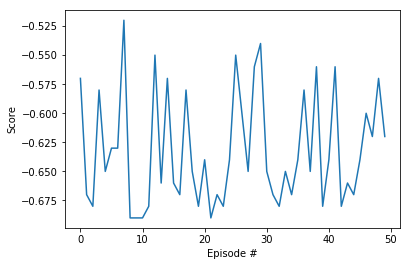

In [35]:
BUFFER_SIZE = int(1e8)        # replay buffer size
BATCH_SIZE = 512              # minibatch size
GAMMA = 0.99                  # discount factor
TAU = 1e-3                    # for soft update of target parameters
LR_ACTOR = 1e-4               # learning rate of the actor 
LR_CRITIC = 3e-4              # learning rate of the critic
WEIGHT_DECAY = 0              # L2 weight decay

DDPG_LEARN_TIMES = 2
DDPG_UPDATE_EVERY = 4

NOISE_EPSILPN_MIN = 1e-2
NOISE_EPSILON = 2.0           # explore/exploit from the noise generator
NOISE_EPSILON_DECAY = 1e-4    # decay rate for noise process

ACTOR_DROPOUT = False         # Actor: use dropout (on last layer)
ACTOR_DROPOUT_RATE = 0.10     # Actor: dropout rate
ACTOR_NORMALIZE = False
ACTOR_NORMALIZE_STATES = True #

CRITIC_DROPOUT = True         # Critic: use dropout (on last layer)
CRITIC_DROPOUT_RATE = 0.20    # Critic: dropout rate
CRITIC_NORMALIZE = False
CRITIC_NORMALIZE_STATES = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

shared_memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, 2)
agents = [Agent(state_size=state_size, action_size=action_size, device=device, random_seed=2, memory = shared_memory,
              ac1=512, ac2=256, cc1=512, cc2=256) for _ in range(2)]

scores = maddpg(50, 2000, early_break = False, memory = shared_memory, print_every = 4)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [36]:
env.close()